In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, FlattenN, Reshape, ExpandN
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor

from learning import Learn, Selector
from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder 

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


creating QM9 dataset...
molecules scanned:  1
molecules created:  0
total molecules scanned:  136
total uncharacterized molecules removed:  2
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  98
CDataset created...
QDataset created...
Data(x=[11, 3], edge_index=[2, 20], edge_attr=[20, 4], y=[1], idx=13, coulomb=[11, 11], distance=[11, 11], adjacency=[11, 11], mulliken=[11, 1], embed1=[29], embed2=[29])


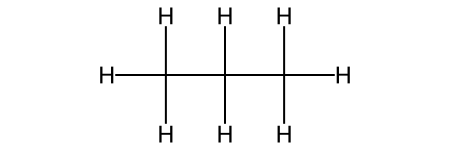

In [2]:
#example cosmosis/qchem dataset with PyG Data object output

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'edge_attr': ['edge_attr'],
                                            'coulomb': ['coulomb'],
                                            'distance': ['distance'],
                                            'adjacency': ['adjacency'],
                                            'mulliken': ['mulliken'],
                                            'embed1': ['hybridization'],
                                            'embed2': ['chirality'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1),AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              'filter_on': ('n_atoms','>','8'), 
                              'n': 100, #non-random subset for testing,
                              'use_pickle': False, #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])
k = qm9.ds_idx[0]
print(qm9[k])
qm9.ds[k].rdmol

In [3]:
#example PyG dataset wrapper PGDS
ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])


In [4]:
#example exploring cosmosis/qchem QM9 dataset

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['mulliken'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  54  length:  17
shortest molecule index:  14  length:  9


Data(x=[9, 3], edge_index=[2, 16], edge_attr=[16, 4], y=[1], idx=14, coulomb=[9, 9], distance=[9, 9], adjacency=[9, 9], mulliken=[9, 1], embed1=[29], embed2=[29])

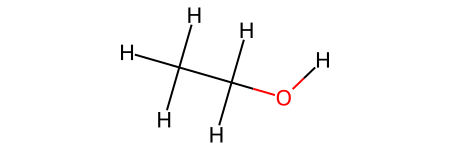

In [5]:
#shortest molecule
qm9.ds[si].rdmol

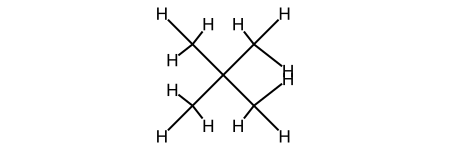

In [6]:
#longest molecule
qm9.ds[li].rdmol

In [3]:
#example creating preprocessed cosmosis/qchem QM9 dataset augmented with
#rdkit mol data (2.7 GB, 133,885 molecules)
#the preprocessing can be greedy or thrifty to optimize speed or memory
#here we are exploring the dataloader and batching

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
                                          
ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             #'hybridization': ['hybridization'],
                                             #'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False, #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])

ds_idx = qm9.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].edge_attr)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  10000
total uncharacterized molecules removed:  273
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9727
CDataset created...
QDataset created...
batch:  DataBatch(x=[35, 3], edge_index=[2, 72], y=[2], idx=[2], batch=[35], ptr=[3])
batch.ptr:  tensor([ 0, 13, 35])
batch.idx:  tensor([ 320, 6542])
batch.x:  tensor([[8., 0., 2.],
        [6., 0., 4.],
        [6., 0., 4.],
        [7., 0., 3.],
        [6., 0., 4.],
        [6., 0., 4.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [6., 0., 4.],
        [8., 0., 2.],
        [6., 0., 4.],
        [6., 0., 4.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        

In [5]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_param = {'train_param': {'dataset': 'QM9',
                              'pg_param': {'root': './data/',
                                            'transform': IndexY(7)}}}

pgds = PGDS(**ds_param['train_param'])
ds_idx = pgds.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[32, 11], edge_index=[2, 62], edge_attr=[62, 4], y=[2], pos=[32, 3], idx=[2], name=[2], z=[32], batch=[32], ptr=[3])
batch.ptr:  tensor([ 0, 16, 32])
batch.idx:  tensor([ 61687, 126355])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0.

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  975
CDataset created...
QDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.834420
epoch: 0, lr: 0.01
train loss: 130.58432006835938, val loss: 44.1465269724528
last 5 targets: 
[-247.21445 -342.3242  -375.4208  -340.6813  -305.1303 ]
last 5 predictions: 
[-249.4356  -269.6052  -286.23346 -333.55573 -285.55115]
test loss: 33.66922696431478

...........................
learning time: 0:00:01.264850
last 5 targets: 
[-308.7419  -154.96036 -270.4112  -285.3136  -323.43777]
last 5 predictions: 
[-310.1031  -242.83925 -293.0228  -315.8011  -302.58798]


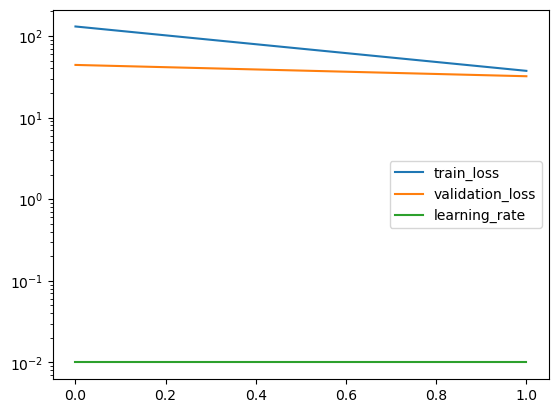

In [4]:
#example using cosmosis/qchem preprocessed QM9 dataset with dictionary output 
#and custom cosmosis/qchem model

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
#cosmosis uses 'X' and 'y' while 'pyg' uses 'x' and 'y'

ds_param = {'train_param': {'input_dict': {'X': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                 'mulliken',
                                                 'coulomb',
                                                  ],
                                             #'idx': ['idx'],
                                             #'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             #'hybridization': ['hybridization'],
                                             #'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [Pad1d(29), AsTensor()],
                                             'aromatic': [Pad1d(29), AsTensor()],
                                             'degree': [Pad1d(29), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False, #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': False}}

model_param = {'in_channels': 29+29+29+29+29*29, #1421=957+464
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel',
               #'embed_param': {'hybridization': (9,8,0,True),
               #                'chirality': (4,8,0,True)},
               #                'flatten': True,
               }      

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013} #early stopping when lr is =<

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .1, #create random subset
                }

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125} #plateau at this value

opt_param = {'lr': 0.01}


l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=12, epochs=2, save_model=False)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:53.410389
epoch: 0, lr: 0.01
train loss: 110260277.15406163, val loss: 79454578.63157895
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-1523.7672 -1857.3455 -2191.5408 -2577.0273 -2576.4238]

...........................
learning time: 0:03:17.395213
epoch: 3, lr: 0.01
train loss: 1794845.5077030812, val loss: 1608349.3371710526
last 5 targets: 
[-10473.517 -11440.859 -11508.856 -11511.891 -11946.602]
last 5 predictions: 
[-11207.428 -11944.055  -8764.527 -10736.488 -11523.094]

...........................
learning time: 0:05:47.681342
epoch: 6, lr: 0.01
train loss: 1177860.7923669468, val loss

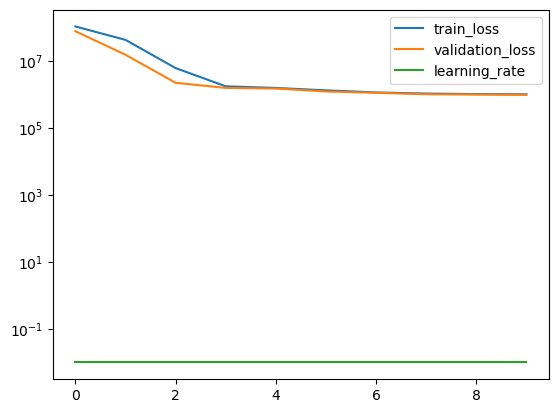

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        #Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'in_channels': 11, 
               'hidden': 128, 
               'out_channels': 1,
               'depth': 2,
               'convolution': 'NetConv', #uses edge features
               'pool': 'MeanAggregation',
               'dropout': .1,
               'softmax': None,
               'activation': 'relu',
               'edge_features': 4,
               }

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': T.Compose([IndexY(7), 
                                                                   ])}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=10)

#cosmosis qm9 feature U0 is in hartree while pyg qm9 U0 (y[7]) is in eV 
#hartree * 27.2114 = eV

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:29.717094
epoch: 0, lr: 0.01
train loss: 97378000.20168068, val loss: 48291980.421052635
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-3856.003  -5417.56   -4377.8706 -5554.9956 -4925.952 ]

...........................
learning time: 0:02:15.270430
epoch: 9, lr: 0.01
train loss: 753026.0091911765, val loss: 727126.4169407894
last 5 targets: 
[-11477.058 -11946.661 -10534.066 -10396.539 -11545.203]
last 5 predictions: 
[-11519.317 -11645.026 -10169.193 -10301.608 -10158.688]
test loss: 761512.1044407894

...........................
learning time: 0:02:20.025640
last 5 targets: 
[ -9554.702 -11

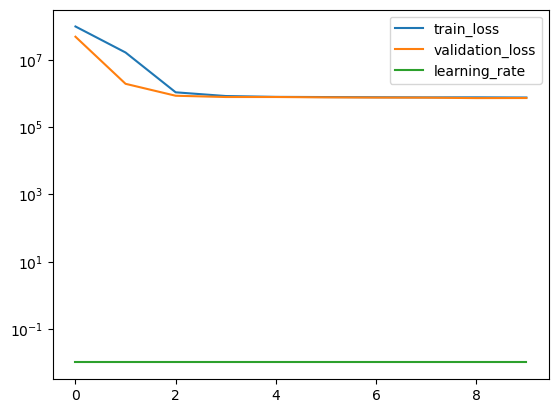

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'in_channels': 11, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

ds_param = {'train_param': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_param': {'root': './data/',
                                            'transform': T.Compose([IndexY(7), 
                                                                   ])}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=10)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
molecules scanned:  10001
molecules created:  9494
total molecules scanned:  10511
total uncharacterized molecules removed:  285
total molecules removed for insuffient rdmol conformations:  511
total molecules created:  9715
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:01.806378
epoch: 0, lr: 0.01
train loss: 122522.17007211539, val loss: 112604.915625
last 5 targets: 
[-422.0659  -360.49924 -314.30124 -326.71185 -386.1596 ]
last 5 predictions: 
[ -4.7024837 -36.274742   -7.344494   -8.28984   -10.639698 ]
test loss: 2065.7818359375

...........................
learning time: 0:00:10.072496
last 5 targets: 
[-304.69174 -361.67337 -365.08005 -342.7659  -274.9831

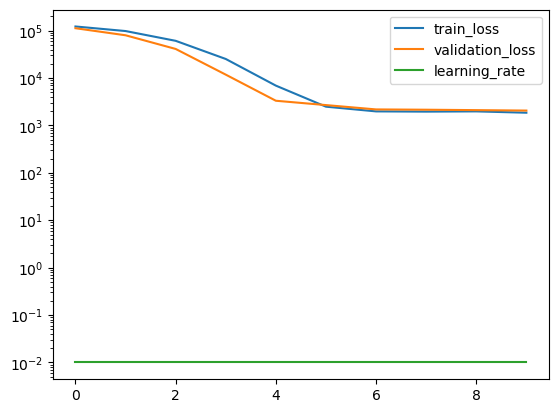

In [3]:
#example cosmosis/qchem QM9 dataset with Data object output with
#custom transforms and sklearn metrics and custom PyG model

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                             'idx': ['idx'],
                                             'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             #'hybridization': ['hybridization'],
                                             #'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','<','10'), 
                              'n': 10000, #non-random subset for testing,
                              'use_pickle': False, #use pickle if exists otherwise create
                              'n_conformers': 3,
                              'dict2data': True}}

model_param = {'in_channels': 3, 
                'hidden': 256, 
                'out_channels': 1,
                'depth': 2,
                'convolution': 'SAGEConv',
                'pool': 'MeanAggregation',
                'dropout': .1,
                'softmax': None,
                'activation': 'relu',
               }

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_param = {'factor': .6,
                'patience': 10,
                'cooldown': 5,
                'min_lr': .00125}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=10, save_model=True, 
          load_model=None)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:01:40.467434
epoch: 0, lr: 0.01
train loss: 0.011132661429058005, val loss: 0.028537109445512684
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.20835222 0.19070938 0.99999964 0.0040467  0.10982273]
sklearn train metric: 0.6142226644568378, sklearn validation metric: 0.5454682212952836

...........................
learning time: 0:03:07.975985
epoch: 1, lr: 0.01
train loss: 0.010013784212874365, val loss: 0.030578571901309724
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.36431658 0.98241514 0.5

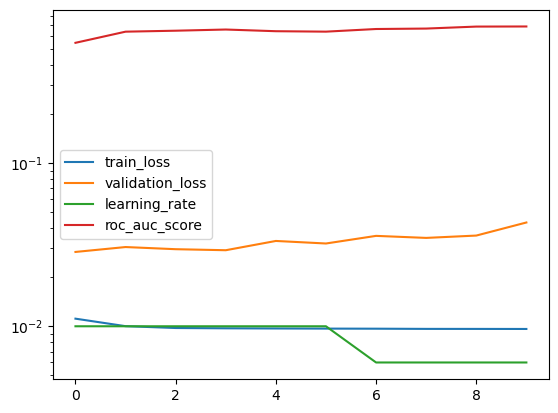

In [2]:
#example graph variational autoencoder without adversarial regulation and GCNConv encoder

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'softmax': None,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

metrics_param = {'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .0013,
                 'sk_metric_name': 'roc_auc_score',
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': False,
              'disc_param': {'in_channels': 32, 'hidden': 64, 
                             'out_channels': 32, 'softmax': None}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': False}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
GraphNet <module 'torch_geometric.nn.conv' from '/home/fltr/miniconda3/envs/qchem/lib/python3.12/site-packages/torch_geometric/nn/conv/__init__.py'> loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
FFNet model loaded...
CModel loaded...
GraphNetVariationalEncoder loaded...
CModel loaded...
running model on gpu...
FFNet model loaded...
CModel loaded...

...........................
learning time: 0:01:55.839394
epoch: 0, lr: 0.01
train loss: 0.019152225004313708, val loss: 0.04293275332333995
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 predictions: 
[0.7968197  0.9999994  0.6132589  0.58804244 0.8343761 ]
sklearn train metric: 0.5114927222316135, sklearn validation metric: 0.5344262488493341

...........................
learning time: 0:05:13.045751
epoch: 2, lr: 0.01
train loss: 0.015908057693313885, val loss: 0.04374139271433057
last 5 targets: 
[0. 0. 0. 0. 0.]
last 5 pre

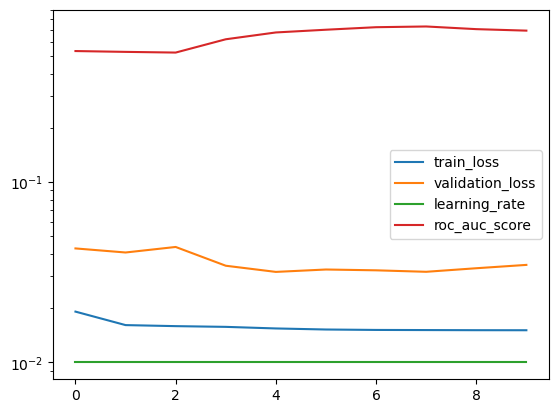

In [2]:
#example graph variational autoencoder with adversarial regulation and GCNConv encoder

model_param = {'in_channels': 11, 
               'hidden': 32, 
               'out_channels': 32,
               'depth': 2,
               'softmax': None,
               'pool': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': None}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013,
                 'sk_metric_name': 'roc_auc_score',
                 'sk_param': {'average': 'macro',
                              'multi_class': 'ovr'}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': True,
              'disc_param': {'in_channels': 32, 'hidden': 64, 
                             'out_channels': 32, 'softmax': None}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': False}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=False, batch_size=128, epochs=10)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
pytorch geometric model GraphSAGE loaded...
running model on gpu...

...........................
learning time: 0:00:29.542055
epoch: 0, lr: 0.01
train loss: 97113752.95238096, val loss: 47395068.2631579
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-4297.003  -5272.1304 -4804.2944 -5373.8105 -4975.5522]

...........................
learning time: 0:02:14.893770
epoch: 9, lr: 0.01
train loss: 706676.4485294118, val loss: 685334.6122532894
last 5 targets: 
[-11477.058 -11946.661 -10534.066 -10396.539 -11545.203]
last 5 predictions: 
[ -9960.292 -12599.446 -10659.112  -9654.73  -10738.172]

...........................
learning time: 0:02:26.574860
epoch: 10, lr: 0.01
train loss: 668981.2303046219, val loss: 634255.0941611842
last 5 targets: 
[-12571.369 -11270.621 -10566.29  -11719.308 -12521.569]
last 5 predictions: 
[-11477.23   -10206.3

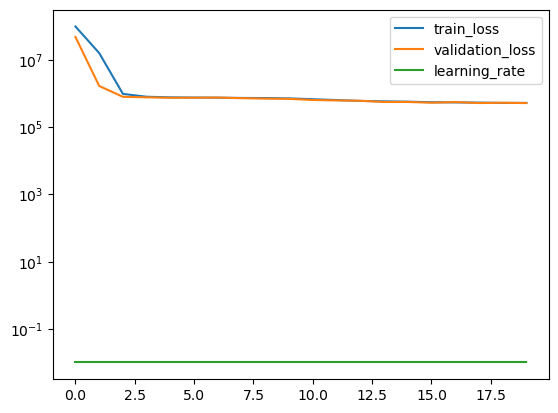

In [2]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custom transforms and sklearn metrics and PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_param = {'model_name': 'GraphSAGE',
               'softmax': None,
               'pool': 'MeanAggregation',
               'ffnet': True,
               'in_channels': 256, #ffnet param
               'hidden': 256, 
               'out_channels': 1, 
               'pyg_param': {'in_channels': 11, #GraphSAGE param
                             'hidden_channels': 256,
                             'num_layers': 2,
                             'out_channels': 256,
                             'dropout': .1,
                             'norm': 'BatchNorm'}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], PygModel, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:41.623270
epoch: 0, lr: 0.01
train loss: 78458382.15406163, val loss: 15486607.52631579
last 5 targets: 
[-10427.34  -11914.588 -10440.464 -12418.075 -10847.889]
last 5 predictions: 
[-5227.773  -8160.319  -7405.637  -8581.778  -6828.8403]

...........................
learning time: 0:02:32.924736
epoch: 5, lr: 0.01
train loss: 192399.60587359944, val loss: 179983.75102796053
last 5 targets: 
[-14638.252 -10631.344 -10937.895 -11510.78   -9555.934]
last 5 predictions: 
[-13433.3545 -10978.653  -11066.358  -11839.801   -9983.8545]

...........................
learning time: 0:04:22.869652
epoch: 10, lr: 0.01
train loss: 177012.51538427873, val loss: 173833.64915707236
last 5 targets: 
[-12571.369 -11270.621 -10566.29  -11719.308 -12521.569]
last 5 predictions: 
[-12758.959 -11678.428 -10752.121 -11969.605 -12353.373

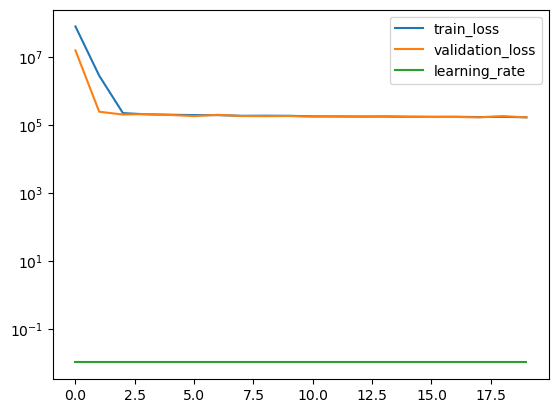

In [4]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_param = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}
#qchem model keys are 'X' and 'y' while pyg used 'x' and 'y'
ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {'y': [Index(7)],
                                           'x': [FlattenN(), Pad1d(29*11)]},
                            'input_dict': {'X': ['x'], 
                                           'y': ['y']},
                            'pg_param': {'root': './data/'}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}



l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.349246
epoch: 0, lr: 0.01
train loss: 1488.7816290604442, val loss: 1402.8089294433594
last 5 targets: 
[-1809.1  -1455.85 -1556.54 -1301.34 -1790.14]
last 5 predictions: 
[-129.24614 -129.48561 -124.99424 -140.39319 -131.89104]

...........................
learning time: 0:00:02.188388
epoch: 10, lr: 0.01
train loss: 44.319951709948086, val loss: 50.4584846496582
last 5 targets: 
[-1285.83 -1591.66 -1587.14 -1356.81 -1700.7 ]
last 5 predictions: 
[-1380.8037 -1627.4858 -1568.9978 -1448.5004 -1710.8962]

...........................
learning time: 0:00:03.936217
epoch: 20, lr: 0.006
train loss: 37.02860561170076, val loss: 34.62798452377319
last 5 targets: 
[-1718.83 -1227.48 -1505.95 -1628.37 -1374.26]
last 5 predictions: 
[-1705.7198 -1186.9565 -1527.6202 -1613.5223 -1343.3324]

...........................
learning time: 0:00:05.766778
epoch: 30, lr: 0

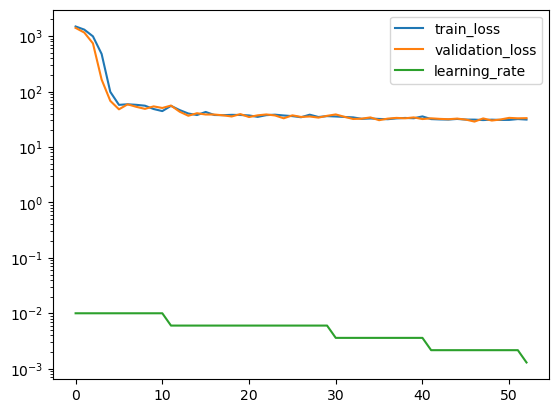

In [5]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_param = {'in_channels': 23*23, 
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['ae']},
                            'in_file': './data/qm7/qm7.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.277379
epoch: 0, lr: 0.01
train loss: 1516.3337595086348, val loss: 1433.6599731445312
last 5 targets: 
[-1918.446  -1878.0168 -1636.8151 -1578.769  -1432.4517]
last 5 predictions: 
[-157.35532  -160.31154  -159.8602   -119.143654  -98.51759 ]

...........................
learning time: 0:00:01.963235
epoch: 10, lr: 0.01
train loss: 65.5737872876619, val loss: 71.64374351501465
last 5 targets: 
[-1516.0977 -1735.5308 -1887.9491 -1618.9104 -1871.8513]
last 5 predictions: 
[-1522.004  -1622.7965 -1706.6744 -1646.982  -1861.2001]

...........................
learning time: 0:00:03.603841
epoch: 20, lr: 0.006
train loss: 50.073611209267064, val loss: 63.97533702850342
last 5 targets: 
[-1475.3118 -1526.9512 -1569.5222 -1275.571  -1624.2003]
last 5 predictions: 
[-1354.8597 -1416.5881 -1509.9832 -1202.6069 -1718.0404]

...........................
learning ti

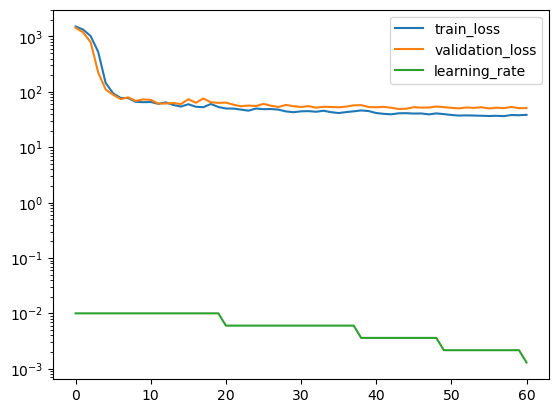

In [7]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_param = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['E']},
                            'in_file': './data/qm7b/qm7b.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, 
          batch_size=256, epochs=200)

In [2]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_param = {'train_param': {'input_dict': {'X': ['atNUM'],
                                           'y': ['eAT']},
                            'transforms': {},
                            'n': 1000, #non-random subset for testing
                            'selector': ['opt']}}

qm7x = QM7X(**ds_param['train_param'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], dtype=float32),
 'y': array([89.31958], dtype=float32)}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:00.812961
epoch: 0, lr: 0.01
train loss: 43.5799072265625, val loss: 11.336931705474854
last 5 targets: 
[46.842625 67.753494 61.9661   68.24363  63.26471 ]
last 5 predictions: 
[44.099133 61.485733 50.97323  58.564766 63.04209 ]
test loss: 3.993863582611084

...........................
learning time: 0:00:01.434877
last 5 targets: 
[64.978455 75.8516   69.59417  57.493458 69.50442 ]
last 5 predictions: 
[77.62272 

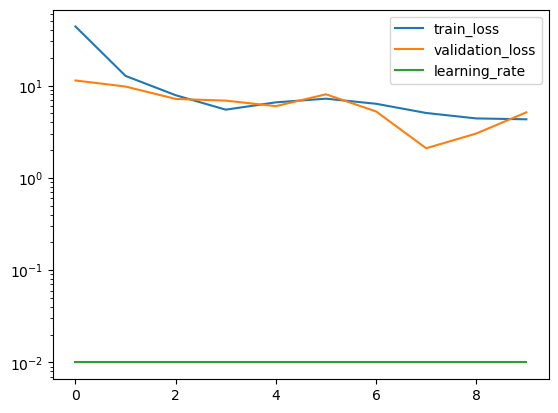

In [2]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_param = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['eAT']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d(23*23)]},
                            'selector': ['opt'],
                            'n': 1000, #non-random subset for testing
                             }}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=64, epochs=10)

In [5]:
#example ANIx1 dataset with pyg Data oject output
ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': True}}

ani1x = ANI1x(**ds_param['train_param'])
k = ani1x.ds_idx[0]
print(k)
ani1x[k]

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
C10H10


Data(y=[1], X=[3969])

In [ ]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model

model_param = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_param = {'train_param': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5',
                              'dict2data': False}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}
sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}

opt_param = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          batch_size=64, epochs=20)